In [1]:
import time
notebook_start = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)
# download a dataset with a description of each column
feat_def = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')

accepted_df = pd.read_csv('data/accepted_16_to_18.csv')
accepted_df.isna().sum()

term                0
int_rate            0
grade               0
dti                 0
loan_status         0
emp_length          0
annual_inc          0
application_type    0
home_ownership      0
issue_d             0
zip_code            0
dtype: int64

In [3]:
# # drop the rows from the definition dataframe with definitions of columns we dropped
# for i in feat_def.index:
#     if feat_def.LoanStatNew[i] not in accepted_df.columns:
#         feat_def.drop(i, inplace=True)
# feat_def

Based on the descriptions of features, I'm gonna choose some columns to keep now and iteratively work my way up from there.

In [4]:
# keep_list=['term', 'int_rate', 'grade', 'dti','loan_status', 'emp_length', 
#            'annual_inc', 'application_type','home_ownership']

# fsm_df = accepted_df[keep_list].copy()
# fsm_df

In [5]:
accepted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482754 entries, 0 to 482753
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   term              482754 non-null  object 
 1   int_rate          482754 non-null  float64
 2   grade             482754 non-null  object 
 3   dti               482754 non-null  float64
 4   loan_status       482754 non-null  int64  
 5   emp_length        482754 non-null  object 
 6   annual_inc        482754 non-null  float64
 7   application_type  482754 non-null  object 
 8   home_ownership    482754 non-null  object 
 9   issue_d           482754 non-null  object 
 10  zip_code          482754 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 40.5+ MB


The features that have binary columns I will just convert to a 1 or 0 manually, so that I know which 1 is which value. I will also do the emp_lenght manually. For the other features I will use a label encoder.

In [6]:
accepted_df['application_type'] = accepted_df['application_type'].map({'Individual': 0, 'Joint App': 1})
accepted_df['term'] = accepted_df['term'].map({' 36 months': 0, ' 60 months': 1})

In [7]:
# fsm_df.emp_length.value_counts()

In [8]:
# emp_length_to_int={'< 1 year':0,
#                       '1 year':1,
#                      '2 years':2,
#                      '3 years':3,
#                      '4 years':4,
#                      '5 years':5,
#                      '6 years':6,
#                      '7 years':7,
#                      '8 years':8,
#                      '9 years':9,
#                      '10+ years':10}
# fsm_df['emp_length'] = fsm_df['emp_length'].map(emp_length_to_int)

In [9]:
le = LabelEncoder()
accepted_df['application_type'] = le.fit_transform(accepted_df['application_type'])
accepted_df['term'] = le.fit_transform(accepted_df['term'])
accepted_df['grade'] = le.fit_transform(accepted_df['grade'])
accepted_df['home_ownership'] = le.fit_transform(accepted_df['home_ownership'])
accepted_df['emp_length'] = le.fit_transform(accepted_df['emp_length'])
accepted_df

,term,int_rate,grade,dti,loan_status,emp_length,annual_inc,application_type,home_ownership,issue_d,zip_code
0,0,11.22,1,3.10,0,7,65000.0,0,1,2016-01-01,201xx
1,0,9.17,1,20.30,0,1,82400.0,0,1,2016-01-01,146xx
2,0,5.32,0,7.43,0,9,200000.0,0,3,2016-01-01,208xx
3,0,10.78,1,2.75,0,6,85000.0,0,4,2016-01-01,908xx
4,0,12.88,2,8.07,1,10,16800.0,0,4,2016-01-01,294xx
...,...,...,...,...,...,...,...,...,...,...,...
482749,0,14.47,2,23.76,0,1,76000.0,0,1,2018-12-01,483xx
482750,0,12.98,1,26.50,0,1,75000.0,0,4,2018-12-01,917xx
482751,0,7.02,0,16.38,0,10,97000.0,0,4,2018-12-01,801xx
482752,0,15.02,2,11.64,0,10,66000.0,0,3,2018-12-01,452xx


In [10]:
accepted_df.isna().sum()

term                0
int_rate            0
grade               0
dti                 0
loan_status         0
emp_length          0
annual_inc          0
application_type    0
home_ownership      0
issue_d             0
zip_code            0
dtype: int64

In [11]:
X = accepted_df.drop(['loan_status', 'issue_d', 'zip_code'],axis=1)
y = accepted_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Using a MinMax scaler because with the Standard scaler I would get Line search warning.

In [12]:
minmax = MinMaxScaler()
X_train_sc = minmax.fit_transform(X_train)
X_test_sc = minmax.transform(X_test)

Here's a baseline model to compare the rest of our models to.

0.6601485900516475

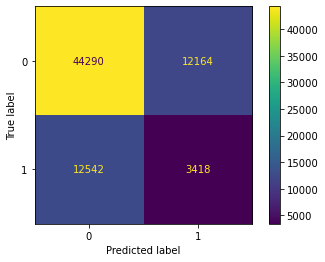

In [13]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_sc, y_train)
plot_confusion_matrix(dummy, X_test_sc, y_test)
dummy.score(X_test_sc, y_test)

Now I'll run a logistic regression in a grid search and cross validate. I hope to iteratively improve the performance of our models.

Prioritizing the "Recall" score in the grid search because we wanna avoid the loans that charged off.

In [14]:
X_train.isna().sum()

term                0
int_rate            0
grade               0
dti                 0
emp_length          0
annual_inc          0
application_type    0
home_ownership      0
dtype: int64

In [57]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'C': [0.01, 0.1, 1, 10]
#     'class_weights': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
    }
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(solver='newton-cg', random_state=42)
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv, scoring='recall')
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Accuracy Score: {test_score}')
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)

{'C': 0.1}


C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\mmnem\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Mean Cross-Val Score: 0.09904296410281468
Train Mean Accuracy: 0.09894210726852994
Accuracy Score: 0.10025062656641603
Recall Score: 0.10025062656641603
Precision Score: 0.525279054497702
F1 Score: 0.16836788382616016


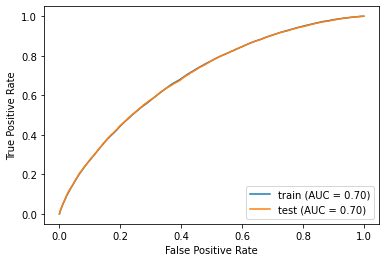

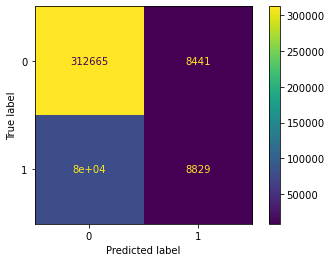

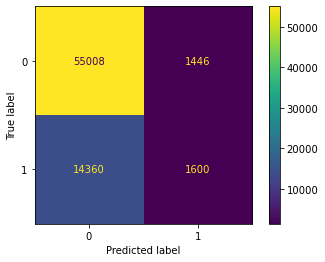

In [58]:
logreg(X_train_sc, X_test_sc, y_train, y_test)

In [17]:
notebook_end = time.time()
print(f'This notebook takes {round(notebook_end - notebook_start, 0)} seconds to run')

This notebook takes 486.0 seconds to run


In [59]:
lr=LogisticRegression(penalty='l2',C=0.01,solver='newton-cg', random_state=42)
lr.fit(X_train_sc,y_train)

LogisticRegression(C=0.01, random_state=42, solver='newton-cg')

Accuracy of Regularized Logistic Regression is: 78.14
Recall of Regularized Logistic Regression is: 52.17


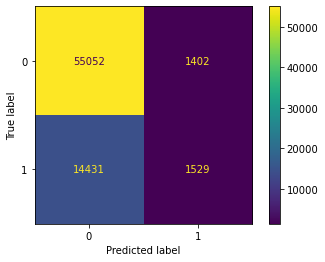

In [60]:
pred_lr = lr.predict(X_test_sc)
accuracy_lr= accuracy_score(pred_lr,y_test)*100
recall_lr = recall_score(pred_lr,y_test)*100
print('Accuracy of Regularized Logistic Regression is: {:.2f}'.format(accuracy_lr))
print('Recall of Regularized Logistic Regression is: {:.2f}'.format(recall_lr))
plot_confusion_matrix(lr, X_test_sc, y_test);

In [61]:
rf = RandomForestClassifier(max_depth=6, random_state=42)
rf.fit(X_train_sc,y_train)

RandomForestClassifier(max_depth=6, random_state=42)

Accuracy of Regularized Random Forest is: 78.14
Recall of Regularized Random Forest is: 59.38


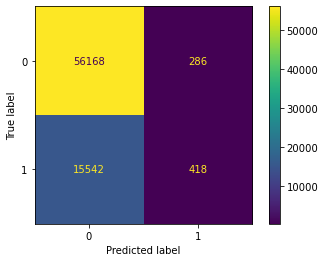

In [62]:
pred_rf = rf.predict(X_test_sc)
accuracy_rf= accuracy_score(pred_rf,y_test)*100
recall_rf = recall_score(pred_rf,y_test)*100
print('Accuracy of Regularized Random Forest is: {:.2f}'.format(accuracy_rf))
print('Recall of Regularized Random Forest is: {:.2f}'.format(recall_rf))
plot_confusion_matrix(rf, X_test_sc, y_test);

In [63]:
precision_score(pred_rf, y_test)

0.02619047619047619